# Study about the effect of Aluminum and Freight Price on Coca-Cola Share price and Something more..

Since production of a can of Coca-Cola beverage relies heavily on package material and transportation cost, this is a projection that maybe the Aluminium and freight cost fluctuation will influence the share price. This is an anlysis.

#### Dataset Collection and Manipulation

In [3]:
import qstock as qs
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import dowhy
from dowhy import CausalModel
from dowhy import plotter

In [4]:
# Try to think about how AHD, BDI and KO are interlinked with each other.

# get coca-cola stock info from qstock, timeframe 2013-01-01 to 2023-09-01
df_KO = qs.get_data('KO',start='20130101',end='20230901')

# add some charactors from standard stock market for coca-cola
df_KO['daily_return'] = df_KO['close'].pct_change()*100 # Daily Return of KO
df_KO['gap_up'] = ((df_KO['open']-df_KO['close'].shift(1))>0).astype(int) # Gap up: the stock market opens higher than the close price the day before.

df_KO['volume%'] = df_KO['volume'].pct_change()
df_KO['ma_20'] = df_KO.close.rolling(20).mean()
df_KO['ma_close'] = df_KO['ma_20'].shift(1)/df_KO.close.shift(1)-1

# signal values for stock trading
df_KO['macd'] = df_KO.ta.macd().iloc[:,0].shift(1)
df_KO['rsi'] = df_KO.ta.rsi().shift(1)

# get the aluminium index from Shanghai Exchange Commodity Index
# get the BDI index (The Baltic Exchange's main sea freight index)
df_AHD = qs.get_data('沪铝主连',start='20130101',end='20230901',freq='d')
df_BDI = qs.get_data('BDI',start='20130101',end='20230901',freq='d')

In [5]:
# join the dataframe together, on the timeframe index of coca-cola
df_AHD = df_AHD.rename(columns={'close':'AHD_close'})
df_BDI = df_BDI.rename(columns={'close':'BDI_close'})
df_KO = df_KO.join([df_AHD['AHD_close'],df_BDI['BDI_close']])

In [6]:
# drop some of the columns that we don't need
df = df_KO.drop(['name', 'code', 'open', 'high', 'low','volume','turnover'],axis=1)

In [25]:
display(df.columns)

Index(['close', 'turnover_rate', 'daily_return', 'gap_up', 'volume%', 'ma_20',
       'ma_close', 'macd', 'rsi', 'AHD_close', 'BDI_close', 'next_gap_up'],
      dtype='object')

In [8]:
def df_null(column:str, dataframe:pd.DataFrame):
    """
    This is to show all the rows with null values in a column "string" in a dataframe.
    """

    problem_df = dataframe[pd.isnull(dataframe[column])]
    print(problem_df)

In [9]:
def df_contains(val,column:str,dataframe:pd.DataFrame):
    ''' 
    display all rows contains certain values in a column
    '''
    mask = dataframe[column]==val & pd.notnull(dataframe[column])
    display(dataframe.loc[mask])

In [10]:
print(df.columns)

Index(['close', 'turnover_rate', 'daily_return', 'gap_up', 'volume%', 'ma_20',
       'ma_close', 'macd', 'rsi', 'AHD_close', 'BDI_close'],
      dtype='object')


<Axes: xlabel='date'>

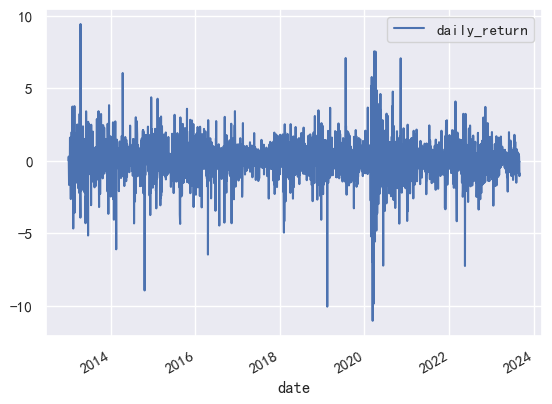

In [11]:
df.plot.line(y='daily_return', use_index=True)

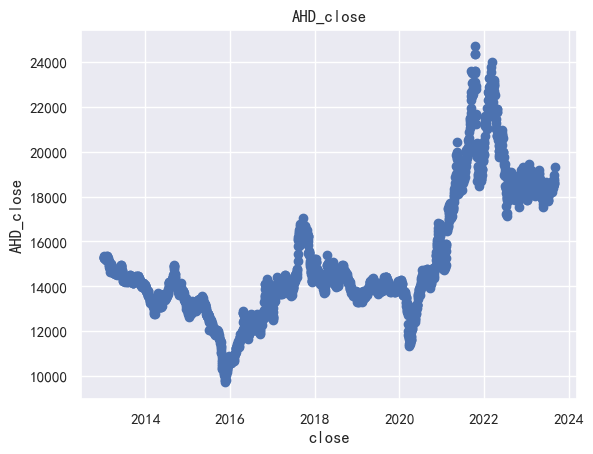

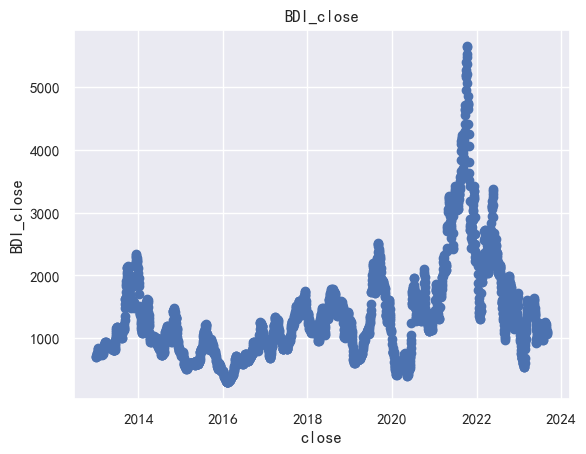

In [12]:
for label in ['AHD_close','BDI_close']:
    plt.scatter(df.index,df[label])
    plt.title(label)
    plt.xlabel("close")
    plt.ylabel(label)
    plt.show()

## Will the Aliuminum and Freight Price affect KO share price?

In [13]:
print(df.columns)

Index(['close', 'turnover_rate', 'daily_return', 'gap_up', 'volume%', 'ma_20',
       'ma_close', 'macd', 'rsi', 'AHD_close', 'BDI_close'],
      dtype='object')


In [14]:
# Will set up a target for the prediction: the next day gap-up.
df['next_gap_up'] = df['gap_up'].shift(-1)
df = df.dropna()

In [15]:
# Using Random Forest model for non-linear analysis, RFC is resistant to overfitting

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=400,min_samples_split=150,random_state=1)



In [16]:
train,test = np.split(df.sample(frac=1),[int(0.8*len(df))])

# train = df.iloc[:-100]
# test = df.iloc[-100:]

predictors = ['AHD_close','BDI_close']
model.fit(train[predictors],train['next_gap_up'])

RandomForestClassifier(min_samples_split=150, n_estimators=400, random_state=1)

In [17]:
# test how good is the prediction (a predicted gap_up is true) 

from sklearn.metrics import precision_score
preds = model.predict(test[predictors])
precision_score(test['next_gap_up'],preds)

In [18]:
# backtesting
def predict(train,test,predictors,model):
    model.fit(train[predictors],train['next_gap_up'])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds>=.6]=1
    preds[preds<.6]=0
    preds = pd.Series(preds,index=test.index,name='Predictions')
    combined = pd.concat([test['next_gap_up'],preds],axis=1)
    return combined

In [19]:
def backtest(data,model,predictors,start,step):
    all_predictions = []

    for i in range(start,data.shape[0],step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors,model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)


In [20]:
predictions = backtest(df,model,predictors,start=int(0.75*len(df)),step=15)

In [21]:
predictions["Predictions"].value_counts()

Predictions
0.0    566
1.0     35
Name: count, dtype: int64

In [22]:
precision_score(predictions['next_gap_up'],predictions['Predictions'])

### Using RNN instead of RandomForrestTree

In [23]:
print(df.columns)

Index(['close', 'turnover_rate', 'daily_return', 'gap_up', 'volume%', 'ma_20',
       'ma_close', 'macd', 'rsi', 'AHD_close', 'BDI_close', 'next_gap_up'],
      dtype='object')


In [26]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

In [27]:
# Set up the new target
predictors = ['AHD_close', 'BDI_close']
target = 'next_gap_up'

# Split the data into training and testing sets, 80/20 for now
train, test = train_test_split(df, test_size=0.2, random_state=1)

In [28]:
# rescale the predictors would help RNN model for better prediction
scaler = StandardScaler()
train[predictors] = scaler.fit_transform(train[predictors])
test[predictors] = scaler.transform(test[predictors])

In [29]:
# set sequences for the RNN
sequence_length = 10  # 10 for now
X_train = []
y_train = []

In [30]:
for i in range(sequence_length, len(train)):
    X_train.append(train[predictors].values[i - sequence_length:i])
    y_train.append(train[target].values[i])

X_train, y_train = np.array(X_train), np.array(y_train)

In [31]:
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=50, activation='relu', input_shape=(sequence_length, len(predictors))),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2)

Epoch 1/50
48/48 [==============================] - 0s 4ms/step - loss: 0.6557 - accuracy: 0.6145 - val_loss: 0.7017 - val_accuracy: 0.5236
Epoch 2/50
48/48 [==============================] - 0s 2ms/step - loss: 0.6501 - accuracy: 0.6086 - val_loss: 0.7094 - val_accuracy: 0.5183
Epoch 3/50
48/48 [==============================] - 0s 2ms/step - loss: 0.6427 - accuracy: 0.6407 - val_loss: 0.7146 - val_accuracy: 0.4817
Epoch 4/50
48/48 [==============================] - 0s 2ms/step - loss: 0.6358 - accuracy: 0.6374 - val_loss: 0.7172 - val_accuracy: 0.4948
Epoch 5/50
48/48 [==============================] - 0s 3ms/step - loss: 0.6330 - accuracy: 0.6518 - val_loss: 0.7202 - val_accuracy: 0.4791
Epoch 6/50
48/48 [==============================] - 0s 2ms/step - loss: 0.6199 - accuracy: 0.6643 - val_loss: 0.7306 - val_accuracy: 0.4764
Epoch 7/50
48/48 [==============================] - 0s 2ms/step - loss: 0.6152 - accuracy: 0.6623 - val_loss: 0.7451 - val_accuracy: 0.4817
Epoch 8/50
48/48 [==

In [39]:
# set sequences for the testing data
X_test = []
y_test = []

In [40]:
for i in range(sequence_length, len(test)):
    X_test.append(test[predictors].values[i - sequence_length:i])
    y_test.append(test[target].values[i])

In [41]:
X_test, y_test = np.array(X_test), np.array(y_test)

In [42]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)

# Evaluate the model
precision = precision_score(y_test, y_pred)
print("Precision:",precision)

15/15 [==============================] - 0s 1ms/step
Precision: 0.45867768595041325


### Continuous Investigation of The relationshop between gap_up and daily_return of KO share

**Gap-Up** means when the opening price of a security is higher than the previous day's closing price.

**DoWhy** is a python package aiming to provide such root couse analysis(RCA). 
The major charactors of DoWhy is:
- Modulise
- Causal Graph
- Multi Causality Models
- Verification

In [31]:
# add two parameters for better intepretation of daily return.
df['mean_lagged_return'] = df['daily_return'].rolling(5).mean().shift(1)
df['var_lagged_return'] = df['daily_return'].rolling(5).var().shift(1)

df.dropna(inplace=True)

In [32]:
# draw the picture of daily_return
qs.line(df['daily_return'])

In [33]:
qs.box(x='gap_up',y='daily_return',data=df)

We can see gap_up = 1 has medium number much higher than gap_up = 0 has. And almost no overlapping between the two suggests a positve effect for gap_up on daily_return. But the presence of numerous outliers may suggest that for some reason, many factors are not factored in the analysis.

In [34]:
# define the causality model and covariates
covariates = ['mean_lagged_return', 'var_lagged_return','volume%','ma_close', 'macd', 'rsi']
model = CausalModel(
    data=df,
    treatment='gap_up',
    outcome='daily_return',
    common_causes=covariates
)

# identify the causality by using backdoor linear regression model
identified_estimand = model.identify_effect()
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression",
    test_significance=True
)
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
   d                                                                          
────────(E[daily_return|rsi,mean_lagged_return,var_lagged_return,volume%,macd,
d[gapᵤₚ]                                                                      

          
ma_close])
          
Estimand assumption 1, Unconfoundedness: If U→{gap_up} and U→daily_return then P(daily_return|gap_up,rsi,mean_lagged_return,var_lagged_return,volume%,macd,ma_close,U) = P(daily_return|gap_up,rsi,mean_lagged_return,var_lagged_return,volume%,macd,ma_close)

## Realized estimand
b: daily_return~gap_up+rsi+mean_lagged_return+var_lagged_return+volume%+macd+ma_close
Target units: ate

## Estimate
Mean value: 0.9306443548287391
p-value: [6.11598336e-62]



DoWhy Conclusion:
- Mean Value is 0.93, it means when gap_up changes from 0 to 1 ,the increase of daily_return is 0.93, with p-value significantly close to 0.
- it assumes that all variates are controlled, which would suggest estimation of causality between gap_up and daily_return is unbiased.

In [35]:
# placebo test is used to check the robustness. the data is replaced by permute data to see if the new estimate is close to 0.
placebo_test = model.refute_estimate(identified_estimand, estimate,method_name="placebo_treatment_refuter", placebo_type="permute")
print(placebo_test)

Refute: Use a Placebo Treatment
Estimated effect:0.9306443548287391
New effect:-0.0014072318986061553
p value:0.98

